In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [42]:
# if A = UDV' then
# A'A = UDV' VDU'= U(D^2)U'
# therefore eig(A'A) == svd(A'A)
# because:
# A'A U = U(D^2) = (D^2) U
# which is of the form
# AX = lambda X

class PCA:
    def __init__(self,n_components):
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.eigenvalues = None
        
    def fit(self, X):
        mu = X.mean(axis=0).reshape((1,-1))
        X_ = X - mu
        cov = np.matmul(X_.T, X_) # (d, d)
        # eigenvectors, eigenvalues = np.linalg.eig(cov) #eigenvectors is column-major
        U, D, Vt = np.linalg.svd(cov)
        eigenvectors = U
        eigenvalues = D
        print(eigenvectors.shape)
        # sort by highest eigvalues
        idx = np.argsort(eigenvalues)[::-1] # descending
        # print(idx)
        components = eigenvectors[:, idx].T
        self.components = components[:self.n_components, :] # n_comp x d
        self.mean = mu
        self.eigenvalues = eigenvalues[idx]
        
    def transform(self, X):
        X_ = X - self.mean # n x d
        # project X_ onto components
        coef = np.matmul(X_, self.components.T)
        return coef
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [230]:
from sklearn.datasets import fetch_lfw_people
import os
if not os.path.exists('./data'):
    os.makedirs('./data')
# Load data
lfw_dataset = fetch_lfw_people(data_home='./data/',min_faces_per_person=100)
_, h, w = lfw_dataset.images.shape
X = lfw_dataset.data
y = lfw_dataset.target
target_names = lfw_dataset.target_names
print(target_names)
print(len(target_names))
print(np.max(X))

X = X/np.max(X)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
5
255.0


In [231]:
from sklearn.model_selection import train_test_split

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape) # N x (2914 pixels)
print(X_test.shape)
print(len(np.unique(y_train)))

(912, 2914)
(228, 2914)
5


In [233]:
pca = PCA(n_components=100)

(2914, 2914)
[1.04182695e+04 8.73954980e+03 4.24814355e+03 ... 3.90740666e-08
 2.13310685e-08 1.29821425e-08]


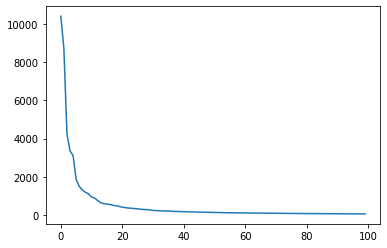

In [234]:
pca.fit(X_train)
print(pca.eigenvalues)
plt.plot(pca.eigenvalues[:100])
plt.show()

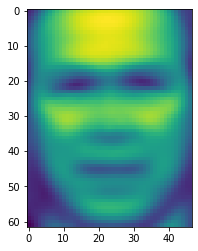

In [235]:
plt.imshow(pca.mean.reshape((h,w)))
plt.show()

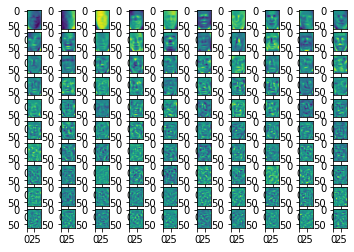

In [236]:
for i, comp in enumerate(pca.components):
    plt.subplot(10,10,i+1)
    plt.imshow(comp.reshape((h,w)))
plt.show()

In [237]:
c = pca.transform(X_test[0])
print(c)

[[-2.23267603e+00  3.65503812e+00  1.15086818e+00 -1.10535264e+00
  -1.31566143e+00 -9.08715785e-01 -1.42235017e+00 -7.81912327e-01
  -2.56735277e+00  5.18294096e-01 -3.89344871e-01 -1.88095903e+00
   6.19860053e-01  2.21505627e-01 -2.55181909e-01 -1.13557577e+00
   1.06499009e-01 -3.08513820e-01 -1.12182903e+00 -5.21239758e-01
  -2.97518432e-01 -3.34390163e-01  2.27907553e-01 -8.09086621e-01
  -1.39710486e+00  9.49357003e-02 -3.41484427e-01 -4.98492658e-01
  -2.06279576e-01  4.57929730e-01  3.67540807e-01 -5.57345748e-01
   1.25572413e-01  2.24923626e-01  4.17667270e-01  1.74226984e-03
  -5.21692038e-01 -1.96347728e-01  2.45934919e-01 -1.95553154e-01
  -6.43218830e-02  1.07428901e-01 -2.05897138e-01 -6.31984353e-01
  -1.62140161e-01  4.46976006e-01 -2.00949520e-01 -1.21855438e-01
  -6.23051047e-01  2.67912686e-01  7.09581077e-02  3.38187456e-01
   2.80780077e-01  5.21594167e-01  3.61858234e-02 -3.46159160e-01
  -1.65158957e-01  2.41529450e-01  2.52935946e-01  2.07513332e-01
   7.46923

In [238]:
# reduce input dimensionality
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [239]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [240]:
class DS(Dataset):
    def __init__(self, data, label, train = True):
        self.data = data
        self.label = label
        self.train = train
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        sample = self.data[index, :]
        lbl = self.label[index]
        return torch.from_numpy(sample), lbl

In [241]:
train_dataset = DS(X_train_pca, y_train, train=True)
test_dataset = DS(X_test_pca, y_test, train=False)
train_dataloader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [242]:
train_dataset[0][0].shape[0]

100

In [243]:
class Classifier(nn.Module):
    def __init__(self, n_input, n_hidden, n_layers, n_classes):
        super().__init__()
        self.fc_in = nn.Linear(n_input, n_hidden)
        self.activation = nn.ReLU()
        layers = []
        for j in range(n_layers):
            layers.append(nn.Linear(n_hidden, n_hidden))
            layers.append(nn.BatchNorm1d(n_hidden))
            layers.append(self.activation)
            
        self.layers = nn.ModuleList(layers)
        self.fc_out = nn.Linear(n_hidden, n_classes)
            
    def forward(self, x):
        x = self.activation(self.fc_in(x))
        for l in self.layers:
            x = l(x)
        return self.fc_out(x)
    
criterion = nn.CrossEntropyLoss()

In [244]:
model = Classifier(train_dataset[0][0].shape[-1], 128, 8, len(np.unique(y_train)))
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Classifier(
  (fc_in): Linear(in_features=100, out_features=128, bias=True)
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=128

In [245]:
from tqdm import tqdm

model.train()
with tqdm(range(100)) as td:
    for epoch in td:
        for batch in train_dataloader:
            optimizer.zero_grad()
            X, y = batch
            ypred = model(X)
            loss = criterion(ypred, y)
            loss.backward()
            optimizer.step()
        td.set_postfix(loss=loss.item())

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.97it/s, loss=0.523]


In [246]:
ys = []
ypreds = []
with torch.no_grad():
    for batch in test_dataloader:
        X, y = batch
        ypred = model(X).argmax(-1)
        print(ypred.shape)
        ys.append(y)
        ypreds.append(ypred)

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([4])


In [247]:
ys = torch.cat(ys, 0).numpy()
ypreds = torch.cat(ypreds, 0).numpy()

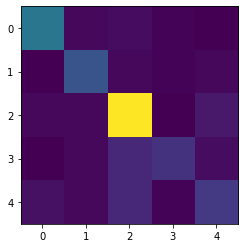

0.753143770353075
0.7014225442579102


In [248]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
m = confusion_matrix(ypreds, ys)
plt.imshow(m)
plt.show()

print(precision_score(ypreds, ys, average="macro"))
print(recall_score(ypreds, ys, average="macro"))

In [249]:
# accuracy
sum(ys==ypreds)/len(ys)

0.7675438596491229